

[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

<br>
  <a href="https://colab.research.google.com/drive/1f-sQfSnk3GsLNvtHvJN1IffsPCMMNA9c?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<br>
(聲明：以下內容都是在網路上整理並修改的，真正我原創的內容並不多，我主要只是搬運工)

要使用的人可以修改資料集(就改 load 資料集那部分就可以了),標記資料的大模型(ontology那邊),微調的目標模型(target model那部分的程式碼)以符合自己的需求。

不過假如訓練(微調時)要修改超參數的話(除了epoch)，可能還是要看下官方文件，然後修改,測試直到符合需求。

# 如何使用Autodistill自動訓練YOLOv8模型

Autodistill利用大型、較慢的基礎模型來訓練小型、更快的監督模型。使用autodistill，您可以從未標記的圖像開始，無需人工干預，直接在邊緣運行自定義模型進行推理。

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

隨著基礎模型(大模型)越來越優秀，它們將越來越能夠在標記過程中輔助或替代人類。我們需要工具來引導、利用和比較這些模型。此外，這些基礎模型很大、昂貴，並且經常被私有API所控制。對於許多生產用例(製造端的應用場景)，我們需要的是能夠在邊緣以低成本和實時運行的模型。

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## 此教學的大綱

在本教學中，我們將涵蓋：

- 檢查 GPU 的設定
- 圖片資料集準備
- 自動標記資料集
- 訓練目標模型
- 評估目標模型
- 執行視頻推理


## 🔥 Let's begin!


## ⚡ 檢查 GPU 的設定


讓我們確保我們有訪問GPU的權限。我們可以使用`nvidia-smi`命令來做到這一點。如果遇到任何問題，請導航到`Edit` -> `Notebook settings` -> `Hardware accelerator`，將其設置為`GPU`，然後點擊`Save`。

In [1]:
!nvidia-smi

Wed Sep 27 08:11:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 🧪 安裝 autodistill

**注意:**  Autodistill是一個生態系統，用於使用大型、較慢的基礎模型來訓練小型、更快的監督模型。每個基礎模型（Base）以及目標模型（Target model）都有其自己獨立的代碼庫和pip包。

In [2]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.1 MB/s eta 0:00:00



**注意：** 為了方便管理數據集、圖像和模型，這邊創建了一個`HOME`常量。






In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 🖼️ 圖像資料集準備

**注意:** 使用Autodistill所需要的就是一組你希望自動標註並用於目標模型訓練的圖像。

In [4]:
!mkdir {HOME}/images


**注意:** 如果您想要在您的資料上構建YOLOv8，請確保將其上傳到我們剛剛建立的`images`目錄中。☝️

### 下載原始影片（可選）

**注意:** 在本教程中，我們將從包含影片文件的目錄開始，我將向您展示如何將其轉換為一組可立即使用的圖像。如果您正在使用您自己的圖像，則可以跳過此部分。

In [5]:
!mkdir {HOME}/videos
%cd {HOME}/videos

# download zip file containing videos
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt" -O milk.zip && rm -rf /tmp/cookies.txt

# unzip videos
!unzip milk.zip

/content/videos
--2023-09-27 08:11:39--  https://docs.google.com/uc?export=download&confirm=t&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt
Resolving docs.google.com (docs.google.com)... 74.125.24.100, 74.125.24.138, 74.125.24.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/adfnpea3l1ijmc47889u0061d2rboe0k/1695802275000/04309230031174164349/*/1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt?e=download&uuid=e4428450-8d83-4116-96e8-c15ea123a2bb [following]
--2023-09-27 08:11:41--  https://doc-08-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/adfnpea3l1ijmc47889u0061d2rboe0k/1695802275000/04309230031174164349/*/1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt?e=download&uuid=e4428450-8d83-4116-96e8-c15ea123a2bb
Resolving doc-08-ag-docs.googleusercontent.com (doc-08-ag-docs.googleusercontent.com)... 74.1

### 將視頻轉換為圖片（可選）

**注意:** 現在，讓我們將視頻轉換為圖片。默認情況下，下面的程式碼會從每個影片中保存每個`10th`第十幀。您可以通過調整`FRAME_STRIDE`參數的值來更改這一點。

In [6]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 3

**注意:**  請注意，我們將兩個影片放在一旁，以便在筆記本的末尾使用它們來評估模型。

In [7]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

print(video_paths)
TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(video_paths):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

[PosixPath('/content/videos/milk-video-1.mov'), PosixPath('/content/videos/milk-video-6.mov'), PosixPath('/content/videos/milk-video-5.mov'), PosixPath('/content/videos/milk-video-8.mov'), PosixPath('/content/videos/milk-video-4.mov'), PosixPath('/content/videos/milk-video-3.mov'), PosixPath('/content/videos/milk-video-7.mov'), PosixPath('/content/videos/milk-video-2.mov')]


  0%|          | 0/8 [00:00<?, ?it/s]

### 顯示圖片樣本

**注意:** 在開始使用autodistill構建模型之前，先檢查下所需的資料。

In [8]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 655


**注意:** 我們也可以繪製我們的圖片數據集的幾個樣本。

In [9]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

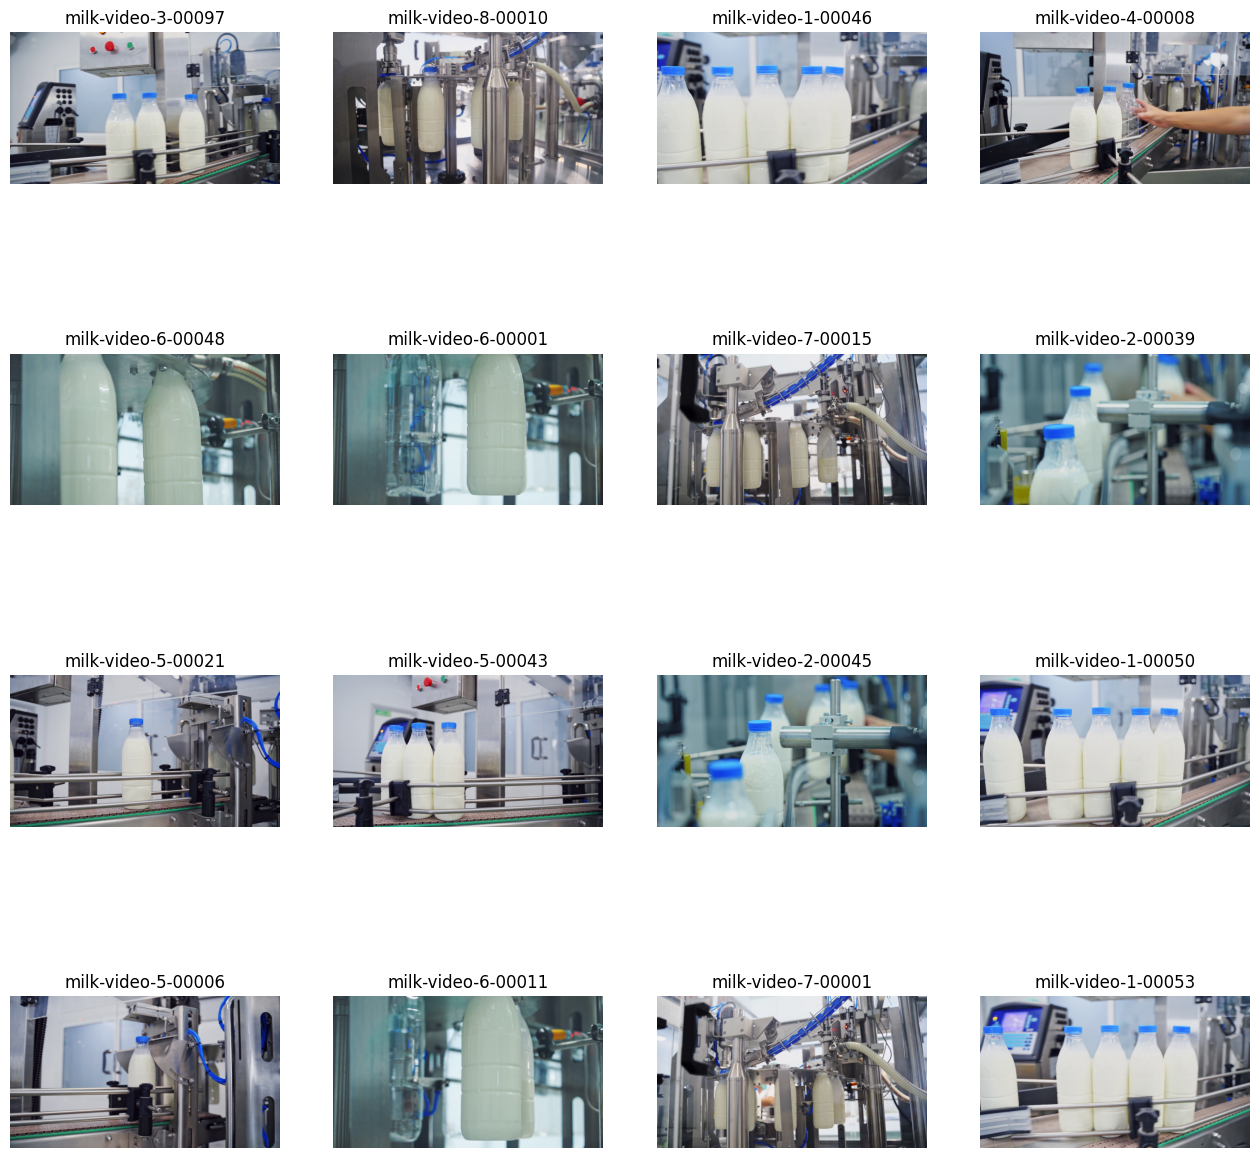

In [10]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ 自動標註資料集


### 定義 ontology 本體

**Ontology 本體** - 本體論定義了你的基礎模型如何被提示(prompt)，你的資料集將描述什麼，以及你的目標模型將預測什麼。CaptionOntology 是個較簡單的本體設定，它用文本標題(Caption)提示基礎模型並將它們映射到類名。其他本體可能會使用CLIP向量或示例圖像設定，而不是文本標題。

In [11]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "car": "car",
    "building": "building"
})

### 初始化基礎模型並自動標記

**基礎模型** - 基礎模型是一個大型的基礎模型，對很多事物都有很多了解。基礎模型通常是多模態的，能夠執行許多任務。它們體積大、速度慢、成本高。基礎模型的例子包括GroundedSAM和即將推出的GPT-4多模態變體。我們使用基礎模型（以及未標記的輸入數據和本體設定）來創建資料集。

In [12]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**注意：:**   基礎模型運行緩慢... 為自己泡杯咖啡，自動標記可能需要一段時間。☕

In [13]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Labeling /content/images/milk-video-3-00097.png:   0%|          | 0/655 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Labeling /content/images/milk-video-5-00012.png: 100%|██████████| 655/655 [36:37<00:00,  3.36s/it]


Labeled dataset created - ready for distillation.



### 展示資料集樣本

**資料集** - 資料集是一組可以用來訓練目標模型的自動標記數據。它是由基礎模型生成的輸出。

In [14]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [15]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

524

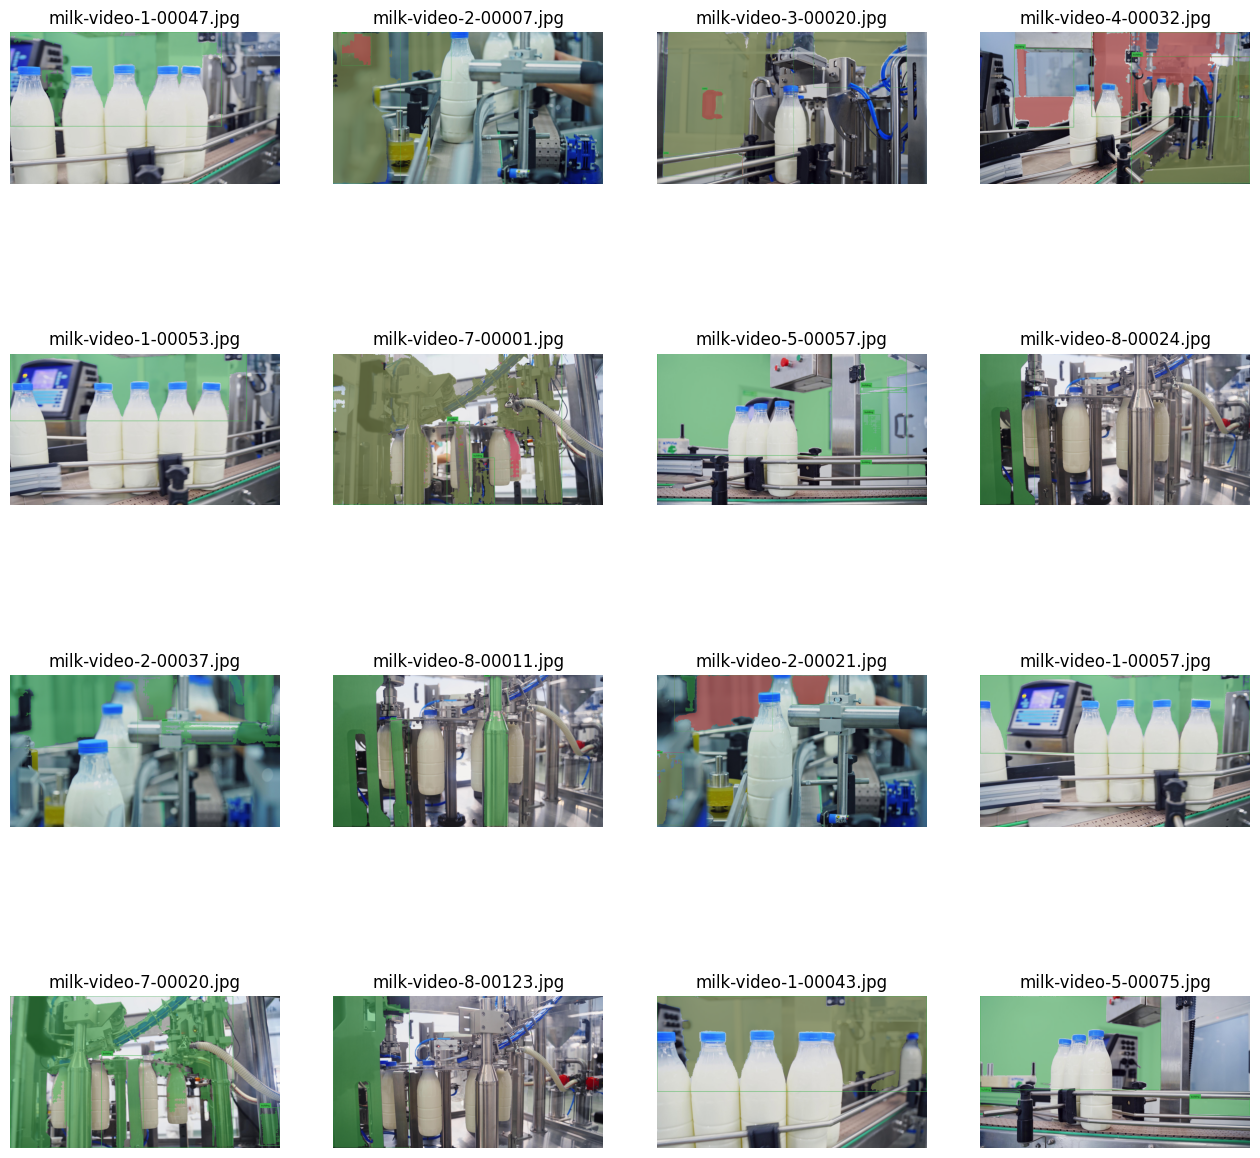

In [16]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)


## 🔥 訓練目標模型 - YOLOv8

**目標模型** - 目標模型是一種監督模型，它消耗一個資料集並輸出一個經過提煉、準備好部署的模型。目標模型通常小巧、快速，並經過微調，以便非常好地執行特定任務（但它們不會很好地泛化到資料集中描述的信息之外）。目標模型的例子包括YOLOv8和DETR。

In [17]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8l.pt")
target_model.train(DATA_YAML_PATH, epochs=100)

/content


100%|██████████| 83.7M/83.7M [00:00<00:00, 396MB/s]
New https://pypi.org/project/ultralytics/8.0.188 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/dataset/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, au

## ⚖️ 評估目標模型

**注意:**  就像常規的YOLOv8訓練一樣，我們現在可以查看存儲在`runs` 目錄中的產物。

/content


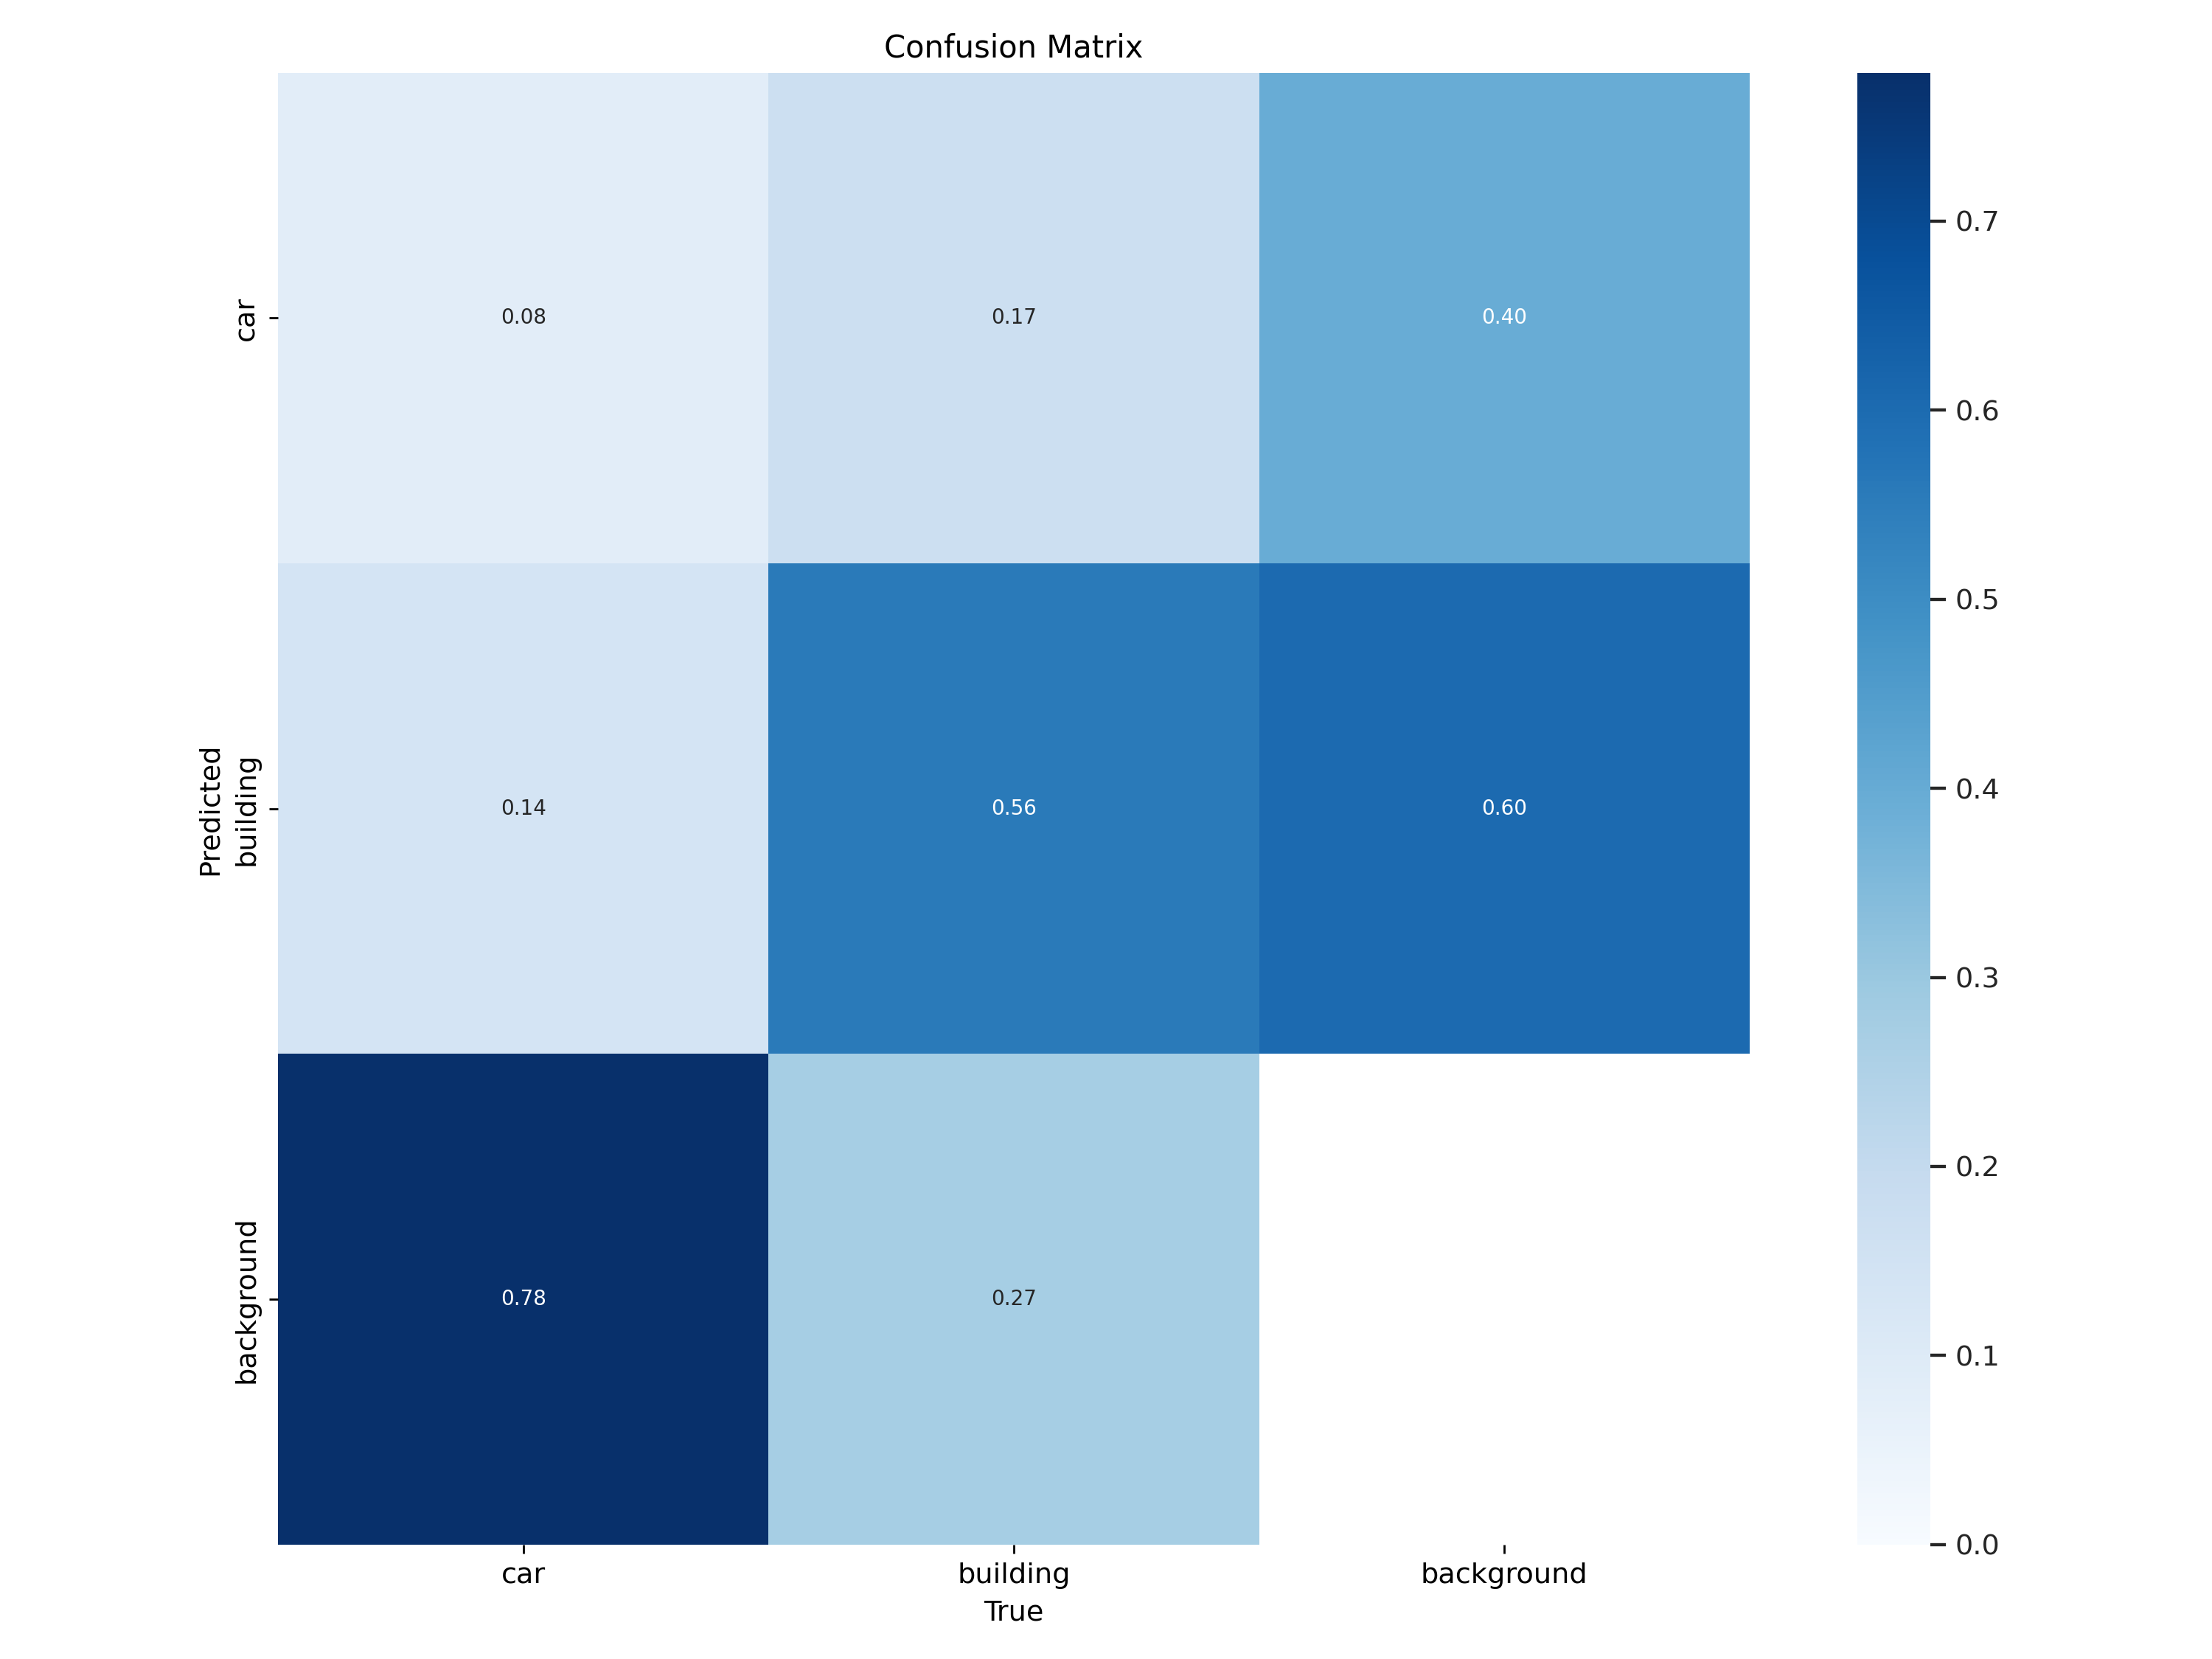

In [18]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


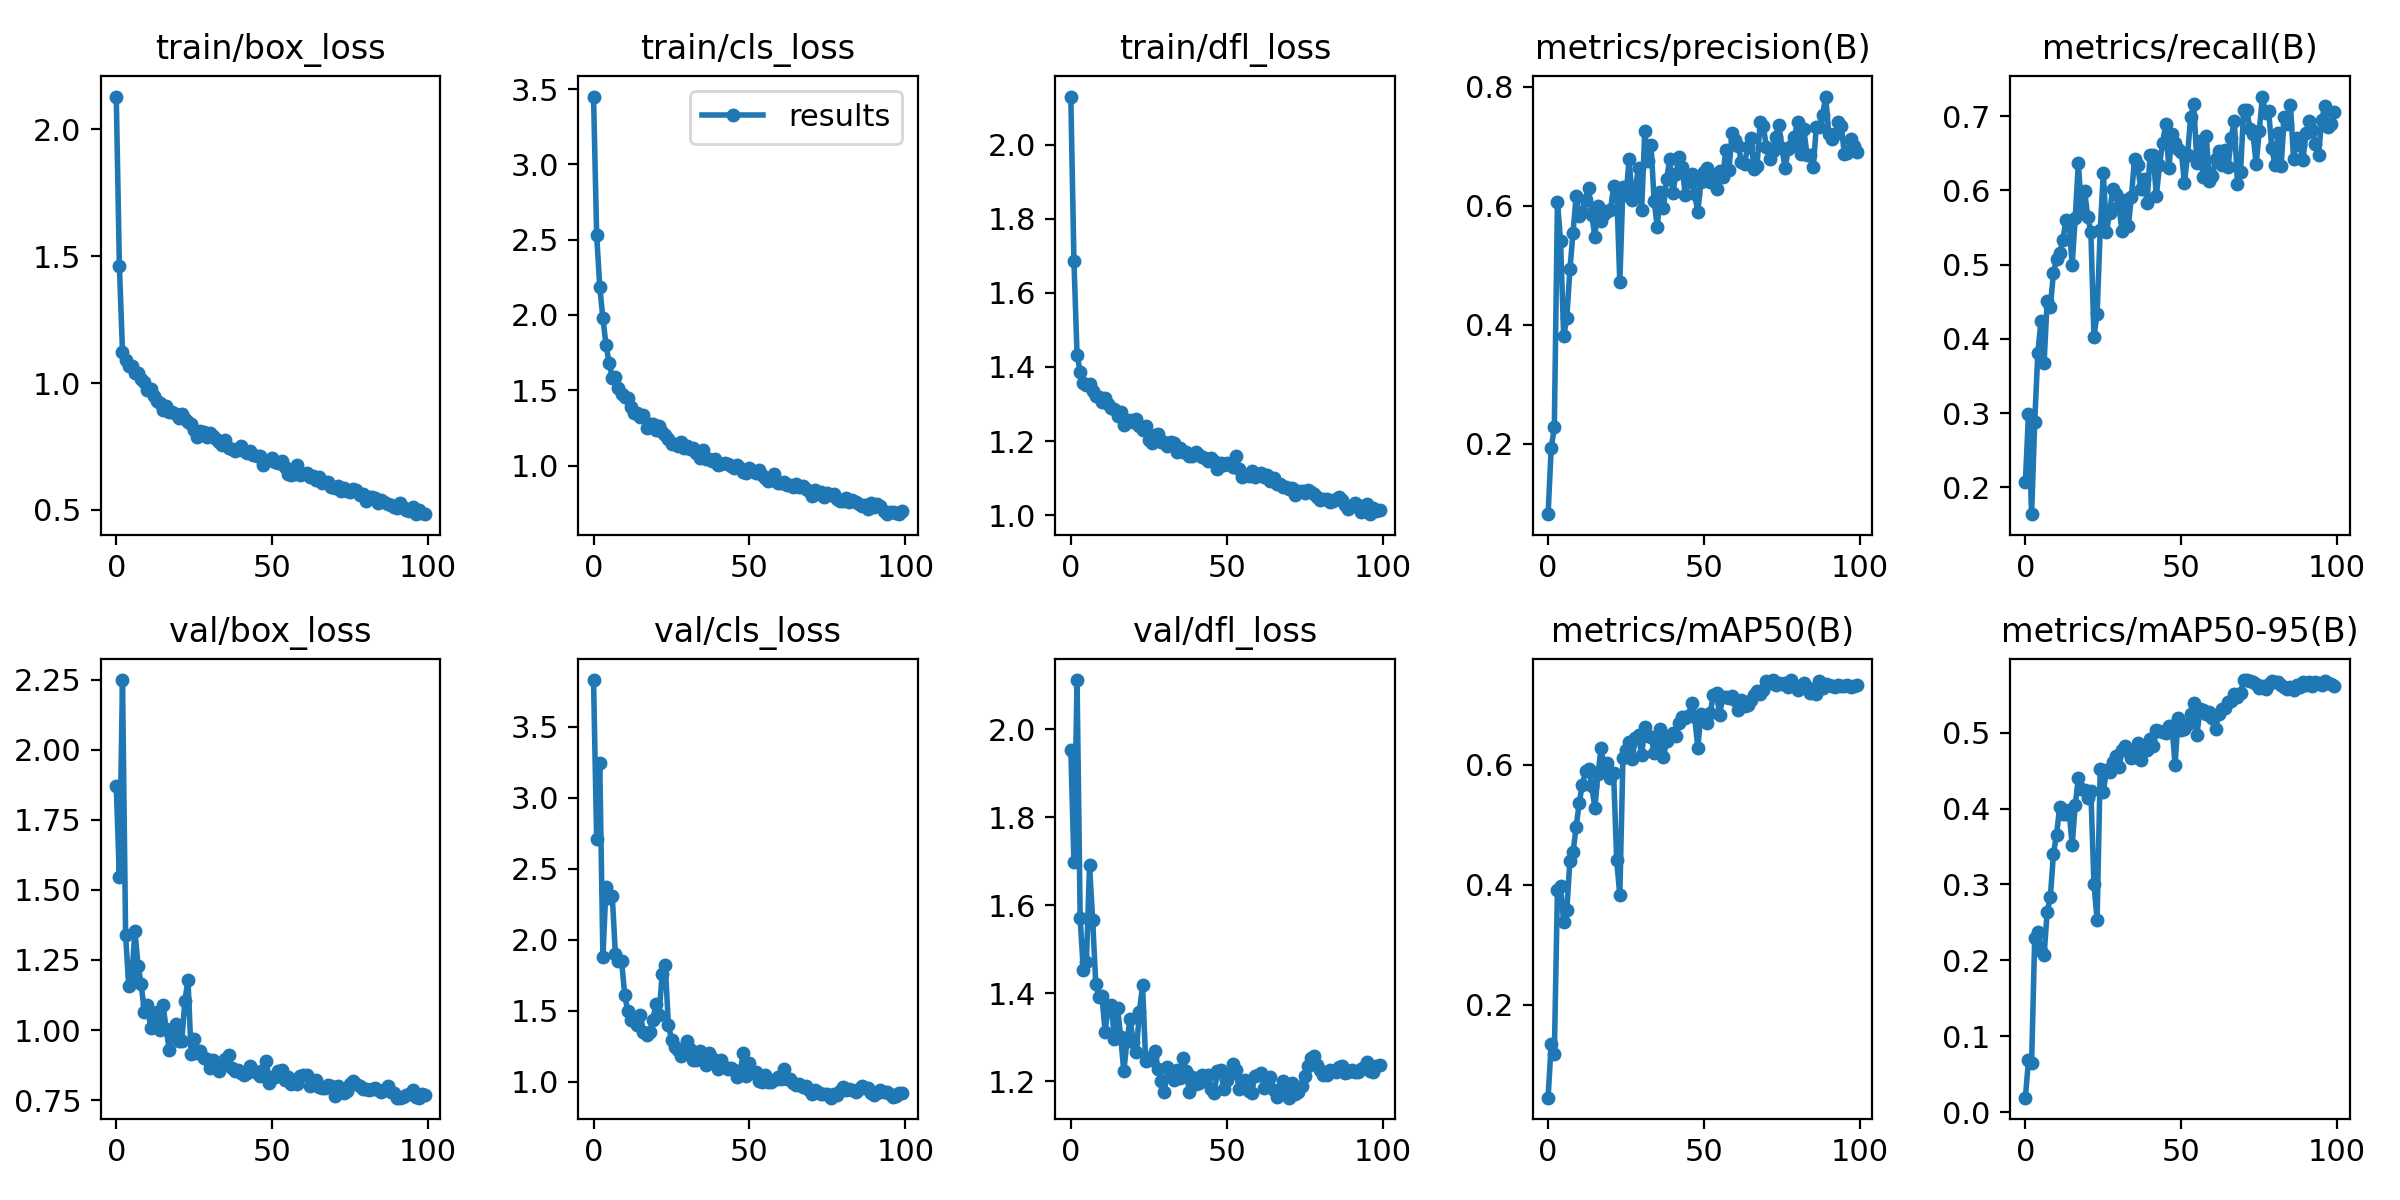

In [19]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


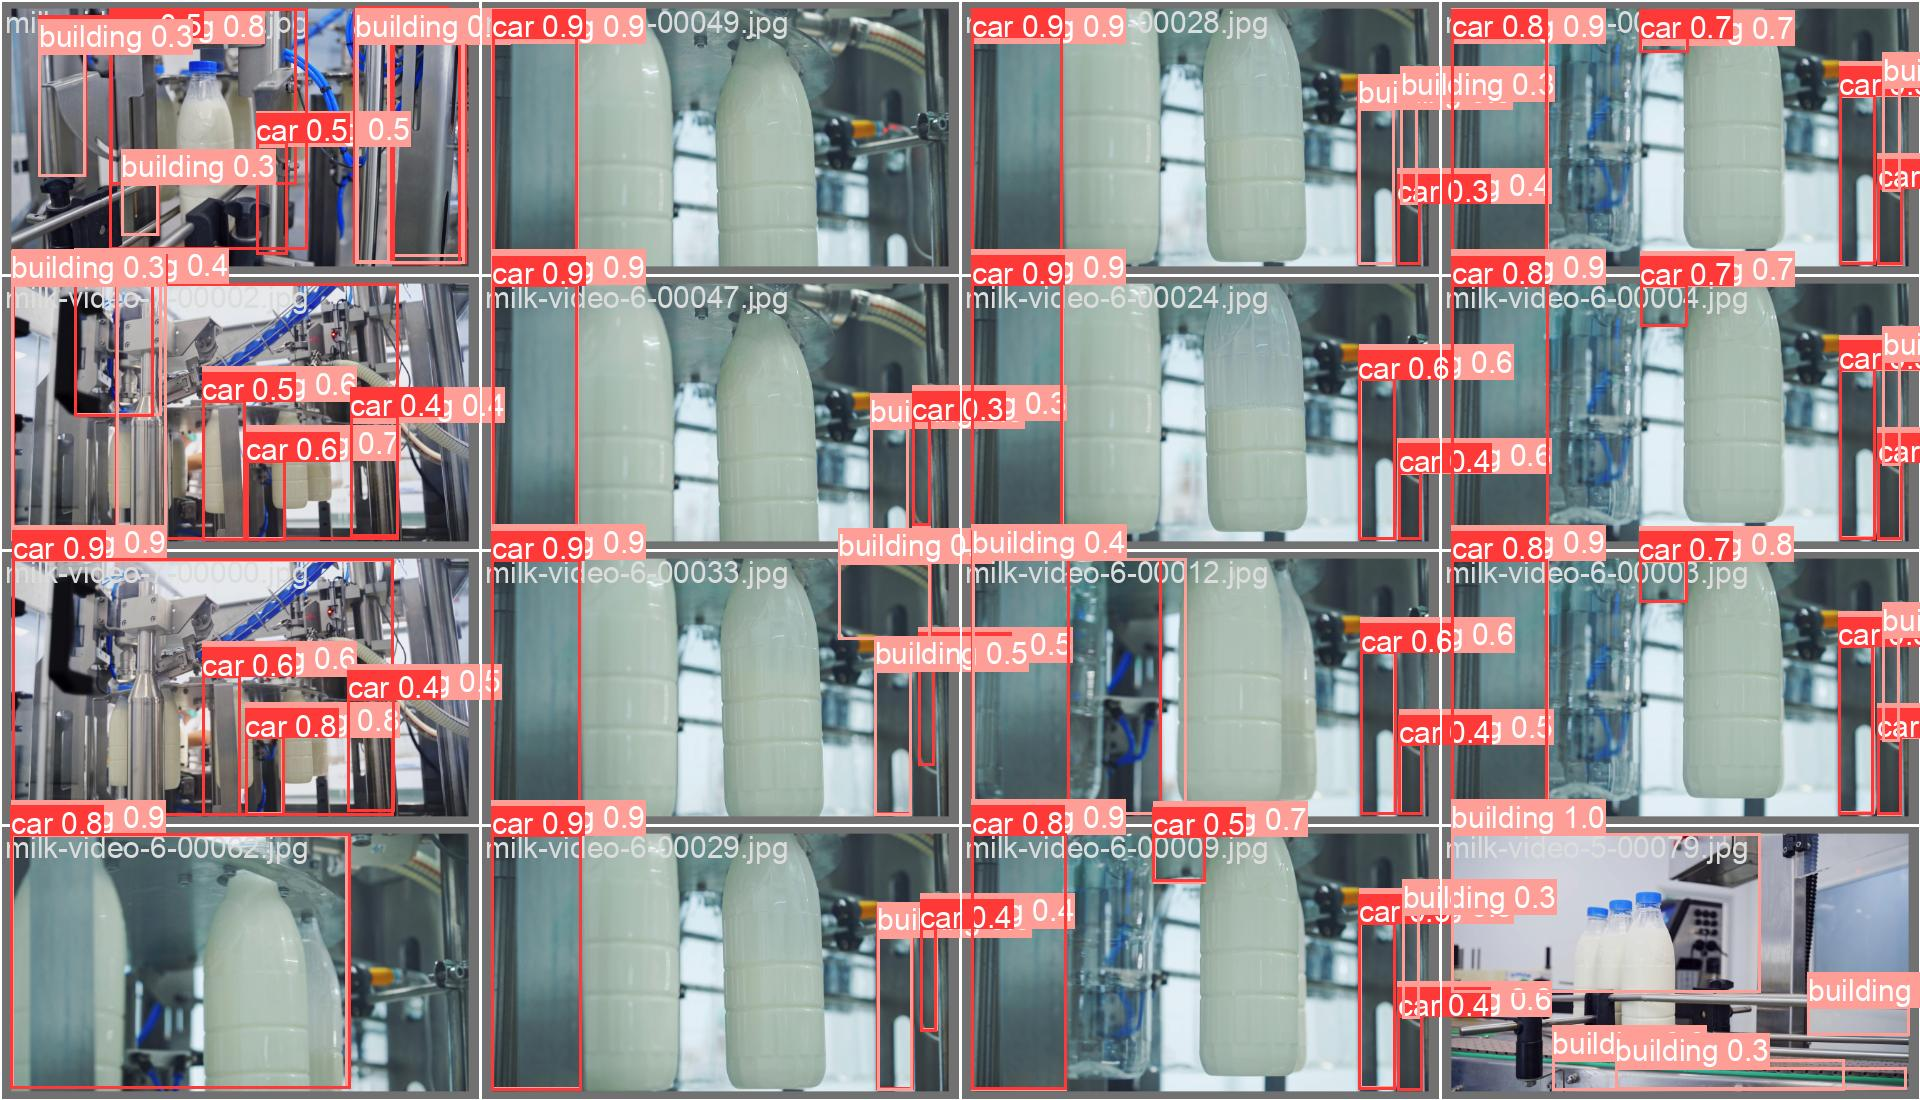

In [20]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## 🎬 對影片進行分析

In [21]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [22]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [23]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43608150 parameters, 0 gradients, 164.8 GFLOPs

video 1/1 (1/188) /content/videos/milk-video-1.mov: 384x640 7 cars, 6 buildings, 67.1ms
video 1/1 (2/188) /content/videos/milk-video-1.mov: 384x640 8 cars, 6 buildings, 39.8ms
video 1/1 (3/188) /content/videos/milk-video-1.mov: 384x640 7 cars, 6 buildings, 39.9ms
video 1/1 (4/188) /content/videos/milk-video-1.mov: 384x640 6 cars, 6 buildings, 38.4ms
video 1/1 (5/188) /content/videos/milk-video-1.mov: 384x640 6 cars, 6 buildings, 30.4ms
video 1/1 (6/188) /content/videos/milk-video-1.mov: 384x640 7 cars, 8 buildings, 30.0ms
video 1/1 (7/188) /content/videos/milk-video-1.mov: 384x640 7 cars, 8 buildings, 29.8ms
video 1/1 (8/188) /content/videos/milk-video-1.mov: 384x640 8 cars, 7 buildings, 29.7ms
video 1/1 (9/188) /content/videos/milk-video-1.mov: 384x640 7 cars, 7 buildings, 29.4ms
video 1/1 (10/188) /content/videos/mil

## 將模型導出

In [24]:
!yolo export model=yolov8n.pt format=onnx half

Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from yolov8n.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 235.4 MB/s eta 0:00:00

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.14.1 opset 17...
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 7.6s, saved as yolov8n.onnx (12.2 MB)

Export complete (8.1s)
Results saved to /content
Predi